## Criaçao de features e modelo

## <a id='ll'>1 Libs</a>

In [34]:
import pandas as pd 
import numpy as np 
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
import string
import time

stop_words = list(set(stopwords.words('russian')))
punctuation = string.punctuation

from sklearn import tree
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re
import gc
import pydot
import scipy

import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import mean_squared_error

In [2]:
pd.set_option('display.max_columns', None)

## <a id='rrtd'>2 Importação dos dados</a>

In [3]:
print("Leitura......")
periods_train = pd.read_csv('../data/periods_train.csv', parse_dates=["activation_date", "date_from", "date_to"])
train = pd.read_csv('../data/train.csv')
print("Ok....")

Leitura......
Ok....


In [4]:
print("train data: ", train.shape)
#print("test data: ", test.shape)
print("periods_train: ", periods_train.shape)
#print("periods_test: ", periods_test.shape)

train data:  (1503424, 18)
periods_train:  (16687412, 4)


## <a id='oot'>2.1 Datasets</a>

**train data**

In [5]:
train.head(3)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.00,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.00,0.13
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.00,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.00,0.00
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.00,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.00,0.43


**periods train data**

In [6]:
periods_train.head(3)

,item_id,activation_date,date_from,date_to
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28


# 3. Geração de features

## 3.1 Conversão do idioma

In [7]:
## Converter Idioma colunas - ['parent_category', 'region', 'city']

parent_category_name_map = {"Личные вещи" : "Personal belongings",
                            "Для дома и дачи" : "For the home and garden",
                            "Бытовая электроника" : "Consumer electronics",
                            "Недвижимость" : "Real estate",
                            "Хобби и отдых" : "Hobbies & leisure",
                            "Транспорт" : "Transport",
                            "Услуги" : "Services",
                            "Животные" : "Animals",
                            "Для бизнеса" : "For business"}

region_map = {"Свердловская область" : "Sverdlovsk oblast",
            "Самарская область" : "Samara oblast",
            "Ростовская область" : "Rostov oblast",
            "Татарстан" : "Tatarstan",
            "Волгоградская область" : "Volgograd oblast",
            "Нижегородская область" : "Nizhny Novgorod oblast",
            "Пермский край" : "Perm Krai",
            "Оренбургская область" : "Orenburg oblast",
            "Ханты-Мансийский АО" : "Khanty-Mansi Autonomous Okrug",
            "Тюменская область" : "Tyumen oblast",
            "Башкортостан" : "Bashkortostan",
            "Краснодарский край" : "Krasnodar Krai",
            "Новосибирская область" : "Novosibirsk oblast",
            "Омская область" : "Omsk oblast",
            "Белгородская область" : "Belgorod oblast",
            "Челябинская область" : "Chelyabinsk oblast",
            "Воронежская область" : "Voronezh oblast",
            "Кемеровская область" : "Kemerovo oblast",
            "Саратовская область" : "Saratov oblast",
            "Владимирская область" : "Vladimir oblast",
            "Калининградская область" : "Kaliningrad oblast",
            "Красноярский край" : "Krasnoyarsk Krai",
            "Ярославская область" : "Yaroslavl oblast",
            "Удмуртия" : "Udmurtia",
            "Алтайский край" : "Altai Krai",
            "Иркутская область" : "Irkutsk oblast",
            "Ставропольский край" : "Stavropol Krai",
            "Тульская область" : "Tula oblast"}


category_map = {"Одежда, обувь, аксессуары":"Clothing, shoes, accessories",
"Детская одежда и обувь":"Children's clothing and shoes",
"Товары для детей и игрушки":"Children's products and toys",
"Квартиры":"Apartments",
"Телефоны":"Phones",
"Мебель и интерьер":"Furniture and interior",
"Предложение услуг":"Offer services",
"Автомобили":"Cars",
"Ремонт и строительство":"Repair and construction",
"Бытовая техника":"Appliances",
"Товары для компьютера":"Products for computer",
"Дома, дачи, коттеджи":"Houses, villas, cottages",
"Красота и здоровье":"Health and beauty",
"Аудио и видео":"Audio and video",
"Спорт и отдых":"Sports and recreation",
"Коллекционирование":"Collecting",
"Оборудование для бизнеса":"Equipment for business",
"Земельные участки":"Land",
"Часы и украшения":"Watches and jewelry",
"Книги и журналы":"Books and magazines",
"Собаки":"Dogs",
"Игры, приставки и программы":"Games, consoles and software",
"Другие животные":"Other animals",
"Велосипеды":"Bikes",
"Ноутбуки":"Laptops",
"Кошки":"Cats",
"Грузовики и спецтехника":"Trucks and buses",
"Посуда и товары для кухни":"Tableware and goods for kitchen",
"Растения":"Plants",
"Планшеты и электронные книги":"Tablets and e-books",
"Товары для животных":"Pet products",
"Комнаты":"Room",
"Фототехника":"Photo",
"Коммерческая недвижимость":"Commercial property",
"Гаражи и машиноместа":"Garages and Parking spaces",
"Музыкальные инструменты":"Musical instruments",
"Оргтехника и расходники":"Office equipment and consumables",
"Птицы":"Birds",
"Продукты питания":"Food",
"Мотоциклы и мототехника":"Motorcycles and bikes",
"Настольные компьютеры":"Desktop computers",
"Аквариум":"Aquarium",
"Охота и рыбалка":"Hunting and fishing",
"Билеты и путешествия":"Tickets and travel",
"Водный транспорт":"Water transport",
"Готовый бизнес":"Ready business",
"Недвижимость за рубежом":"Property abroad"}

params_top35_map = {'Женская одежда':"Women's clothing",
                    'Для девочек':'For girls',
                    'Для мальчиков':'For boys',
                    'Продам':'Selling',
                    'С пробегом':'With mileage',
                    'Аксессуары':'Accessories',
                    'Мужская одежда':"Men's Clothing",
                    'Другое':'Other','Игрушки':'Toys',
                    'Детские коляски':'Baby carriages', 
                    'Сдам':'Rent',
                    'Ремонт, строительство':'Repair, construction',
                    'Стройматериалы':'Building materials',
                    'iPhone':'iPhone',
                    'Кровати, диваны и кресла':'Beds, sofas and armchairs',
                    'Инструменты':'Instruments',
                    'Для кухни':'For kitchen',
                    'Комплектующие':'Accessories',
                    'Детская мебель':"Children's furniture",
                    'Шкафы и комоды':'Cabinets and chests of drawers',
                    'Приборы и аксессуары':'Devices and accessories',
                    'Для дома':'For home',
                    'Транспорт, перевозки':'Transport, transportation',
                    'Товары для кормления':'Feeding products',
                    'Samsung':'Samsung',
                    'Сниму':'Hire',
                    'Книги':'Books',
                    'Телевизоры и проекторы':'Televisions and projectors',
                    'Велосипеды и самокаты':'Bicycles and scooters',
                    'Предметы интерьера, искусство':'Interior items, art',
                    'Другая':'Other','Косметика':'Cosmetics',
                    'Постельные принадлежности':'Bed dress',
                    'С/х животные' :'Farm animals','Столы и стулья':'Tables and chairs'}

In [8]:
## Convert Russian to English

## Train
train['region_english'] = train['region'].apply(lambda x : region_map[x])
train['parent_category_name_english'] = train['parent_category_name'].apply(lambda x : parent_category_name_map[x])
train['category_name_english'] = train['category_name'].apply(lambda x : category_map[x])

## 3.2 Parametros

In [9]:
## Combinar as features Param 1, 2 e 3 

train['param_combined'] = train.apply(lambda row: ' '.join([str(row['param_1']), str(row['param_2']),  str(row['param_3'])]), axis=1)
train['param_combined'] = train['param_combined'].fillna(" ")
train['param_combined_len'] = train['param_combined'].apply(lambda x : len(x.split()))

## 3.3 Data de ativação 

**Novas features a partir de activation_date e periods_train :**

 - month
 - weekday
 - month_day
 - days_up

In [10]:
train['activation_date'] = pd.to_datetime(train['activation_date'])

# Train
train["month"] = train["activation_date"].dt.month
train['weekday'] = train['activation_date'].dt.weekday
train["day"] = train['activation_date'].dt.day
#train["year_Day"] = train['activation_date'].dt.dayofyear

## Fill NaN
train["description"].fillna("NA", inplace=True)

# periods_train
periods_train['total_period'] = periods_train['date_to'] - periods_train['date_from']

In [11]:
# periods_train['days_up'] = periods_train['date_to'].dt.dayofyear - periods_train['date_from'].dt.dayofyear
# ## Insere feature days_up nos dados de treino
# train = train.merge(periods_train.set_index('item_id').loc[:, 'days_up'], on='item_id', how='left')


# periods_train = periods_train.merge(train.loc[:, 'item_id':'user_id'], on='item_id', how='left')
# n_user_items = train.groupby(['user_id'])[['item_id']].count().reset_index().rename(index=str, columns={'item_id': 'n_user_items'})
# gp = periods_train.groupby(['user_id'])
# train = train.merge(n_user_items, on='user_id', how='outer')

## 3.4 Variáveis textuais

Criar novas features :
* **char_count**
* **word_count**
* **word_density**
* **punctuation_count**
* **unique_word**
* **upper_case_word_count**
* **stopword_count**

In [12]:
start_time=time.time()

# Char count
#train['d_length'] = train['description'].apply(lambda x: len(str(x))) 
train['char_count_desc'] = train['description'].apply(lambda x: len(str(x)))
train['char_count_title'] = train['title'].apply(lambda x: len(str(x)))

# Word count
train['word_count_desc'] = train['description'].apply(lambda x: len(str(x).split()))
train['word_count_title'] = train['title'].apply(lambda x: len(str(x).split()))

# Word density 
train['word_density_desc'] = train['char_count_desc'] / (train['word_count_desc']+1)
train['word_density_title'] = train['char_count_title'] / (train['word_count_title']+1)

# Ponctuation 
train['punctuation_count_desc'] = train['description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation])) 
train['punctuation_count_title'] = train['title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Unique words
train['unique_word_desc'] = train['description'].apply(lambda x: len(set(str(x).split())))
train['unique_word_title'] = train['title'].apply(lambda x: len(set(str(x).split())))

# Upper case
train['upper_case_word_count_desc'] = train['description'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
train['upper_case_word_count_title'] = train['title'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Stopwords count
train['stopword_count_desc'] = train['description'].apply(lambda x: len([wrd for wrd in str(x).split() if wrd.lower() in stop_words]))
train['stopword_count_title'] = train['title'].apply(lambda x: len([wrd for wrd in str(x).split() if wrd.lower() in stop_words]))

#Average length of the words
train["mean_word_len_title"] = train["title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
train["mean_word_len_desc"] = train["description"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

end_time=time.time()
print("time:  ",end_time-start_time,"s")

time:   139.8134264945984 s


## 3.4 Variáveis categoricas

   - region
   - city
   - parent_category_name
   - category_name
   - user_type
   - param_1
   - param_2
   - param_3
   - preço (6 classes)

In [14]:
# Label encode the categorical variables
cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3", ]

for col in cat_vars:
    lb = preprocessing.LabelEncoder()
    lb.fit(list(train[col].values.astype('str')))
    train[col] = lb.transform(list(train[col].values.astype('str')))

In [15]:
## preço

max_price = train['price'].max()
min_price = train['price'].min()

bins = [min_price, max_price*0.1, max_price*0.25, max_price*0.5, max_price*0.75, max_price]
names = ['<10', '10-25', '25-50', '50-75', '>75']

train['price_bins'] = pd.cut(train['price'], bins, labels=names)

In [16]:
# Label encode the categorical variables
cat_vars = ['price_bins']
for col in cat_vars:
    lb = preprocessing.LabelEncoder()
    lb.fit(list(train[col].values.astype('str')))
    train[col] = lb.transform(list(train[col].values.astype('str')))

## 3.5 Remover features não utilizadas

- item_id
- user_id
- title
- description
- activation_date
- image
- region_en
- parent_category_name_en
- category_name_en

In [17]:
cols_to_drop = ["item_id", "user_id", "title", "description", "activation_date", "image", 'param_combined']

## Dataset para o Modelo
train_df = train.drop(cols_to_drop + ["region_english", "parent_category_name_english", "category_name_english"], axis=1)

## Drop NA
# train_df = train_df.dropna(axis=1, how='any')
# test_df = test_df.dropna(axis=1, how='any')
gc.collect()

0

In [18]:
train_df.head()

,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,item_seq_number,user_type,image_top_1,deal_probability,param_combined_len,month,weekday,day,char_count_desc,char_count_title,word_count_desc,word_count_title,word_density_desc,word_density_title,punctuation_count_desc,punctuation_count_title,unique_word_desc,unique_word_title,upper_case_word_count_desc,upper_case_word_count_title,stopword_count_desc,stopword_count_title,mean_word_len_title,mean_word_len_desc,price_bins
0,19,460,4,42,249,107,1162,400.00,2,1,1008.00,0.13,4,3,1,28,58,21,7,3,7.25,5.25,2,2,7,3,0,0,1,1,6.33,7.43,0
1,17,1300,2,22,122,107,1162,3000.00,19,1,692.00,0.00,3,3,6,26,41,17,7,3,5.12,4.25,3,0,7,3,1,0,3,1,5.00,5.00,0
2,16,1276,0,2,84,107,1162,4000.00,9,1,3032.00,0.43,7,3,0,20,99,14,17,2,5.50,4.67,5,0,17,2,2,0,4,0,6.50,4.88,0
3,21,940,4,42,38,107,1162,2200.00,286,0,796.00,0.80,4,3,5,25,22,10,3,1,5.50,5.00,1,0,3,1,0,0,0,0,10.00,6.67,0
4,4,317,6,0,278,119,44,40000.00,3,1,2264.00,0.21,5,3,3,16,24,14,4,3,4.80,3.50,1,1,4,3,0,1,2,0,4.00,5.25,0


In [19]:
train_df.shape

(1503424, 33)

In [20]:
########################################

# 4. Modelo

In [22]:
train_df.dropna(inplace=True)
x = train_df.drop(['deal_probability'], axis=1)
y = train_df['deal_probability'].values
print(x.shape)
print(y.shape)

(1331625, 32)
(1331625,)


In [23]:
x_train, x_rem, y_train, y_rem = train_test_split(x, y, test_size=0.3, random_state=0)
x_test, x_val, y_test, y_val = train_test_split(x_rem, y_rem, test_size=0.5, random_state=0)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(932137, 32)
(932137,)
(199744, 32)
(199744,)
(199744, 32)
(199744,)


In [30]:
# Create the LightGBM data containers
train_data = lightgbm.Dataset(x_train, label=y_train)
val_data = lightgbm.Dataset(x_val, label=y_val)

# Train the model
parameters = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 63,
    'max_depth': 15,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}


model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=val_data,
                       num_boost_round=2000,
                       early_stopping_rounds=50,
                       verbose_eval=100)

#y_pred = model.predict(x_test)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.229837
[200]	valid_0's rmse: 0.228486
[300]	valid_0's rmse: 0.227803
[400]	valid_0's rmse: 0.227414
[500]	valid_0's rmse: 0.227173
[600]	valid_0's rmse: 0.226903
[700]	valid_0's rmse: 0.226725
[800]	valid_0's rmse: 0.226561
[900]	valid_0's rmse: 0.226467
[1000]	valid_0's rmse: 0.226407
[1100]	valid_0's rmse: 0.226327
[1200]	valid_0's rmse: 0.226263
[1300]	valid_0's rmse: 0.226189
[1400]	valid_0's rmse: 0.226115
[1500]	valid_0's rmse: 0.226052
[1600]	valid_0's rmse: 0.226027
[1700]	valid_0's rmse: 0.226
[1800]	valid_0's rmse: 0.225944
[1900]	valid_0's rmse: 0.225924
[2000]	valid_0's rmse: 0.22589
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 0.22589


In [37]:
# Pred
y_pred = model.predict(x_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

0.2246162721392105

Text(0.5, 1.0, 'Light GBM Feature Importance')

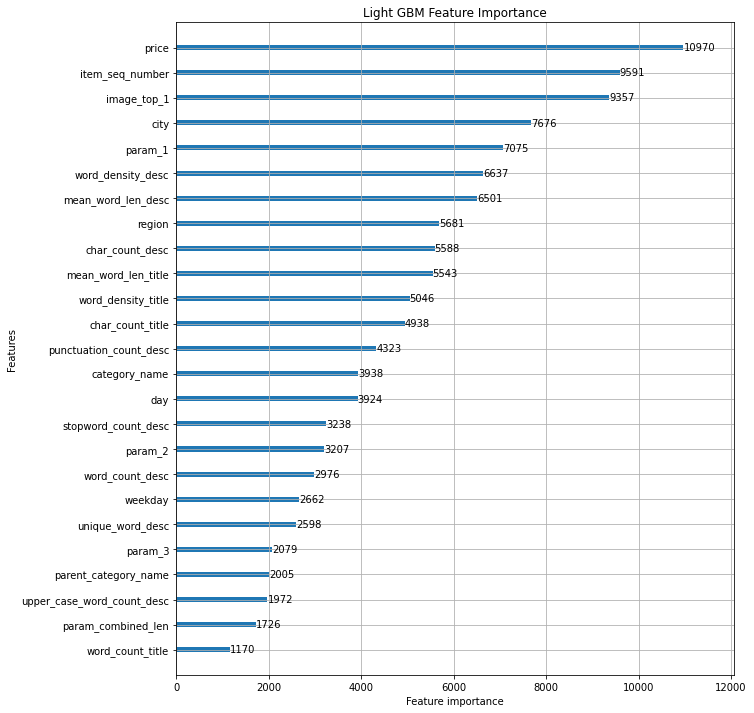

In [31]:
fig, ax = plt.subplots(figsize=(10, 12))
lgb.plot_importance(model, max_num_features=25, ax=ax)
plt.title("Light GBM Feature Importance")

In [32]:
## As features criadas word_density_description, , mean_word_len apresentam importancia relevante na determinacao da probabilidade de venda.

In [27]:
import pickle

with open('lightgbm.pkl','wb') as f:
    pickle.dump(model,f)

**Implementações**

- Validação cruzada K-Fold.
- Comparar a outros modelos de regressão.
- Inserir uma dimensão temporal como número de itens que um usuário coloca à venda por dia.
- Incluir recursos de texto como embeddings com palavras pré-treinadas.
- Utilizar o dataset de imagens para extração de novas features.
- Criar uma aplicação dash par exposição dda análise exploratória e o resultado do modelo.
